In [1]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import time
import pandas as pd
import os
import shapely 

from shapely.geometry import Point, Polygon, LineString, MultiLineString, MultiPolygon
from shapely import affinity
from shapely.ops import split, snap, linemerge
from itertools import combinations
from random import randint

In [2]:
cdir = os.getcwd() 
path = os.path.dirname(cdir) + "/geojson_polygons"

glasgow = gpd.read_file(f"{path}/glasgow.geojson")#.to_crs(3857)#.buffer(3000,join_style=2).to_crs(4326))
glasgow_pd = gpd.read_file(f"{path}/glasgow_polling_districts.geojson")

print(glasgow.area)

0    0.025301
dtype: float64


/tmp/ipykernel_6817/2692964593.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(glasgow.area)


In [3]:
# features_from_bbox takes bbox as [north, south, east, west]
# so a reorder of total_bounds is needed (it goes minx, miny, maxx, maxy)
bb = glasgow.total_bounds
bb[0], bb[1], bb[2], bb[3] = bb[3], bb[1], bb[2], bb[0] 

tags = {"highway" : True}
#tags = {"highway" : True, "railway" : True, "waterway" : True}
ways = ox.features_from_bbox(bbox=bb, tags=tags)
ways = ways.loc[ways.geometry.type=='LineString']
ways = ways.loc[ways.highway!="footway"]
ways_clip = gpd.clip(ways, glasgow)

KeyboardInterrupt: 

<Axes: >

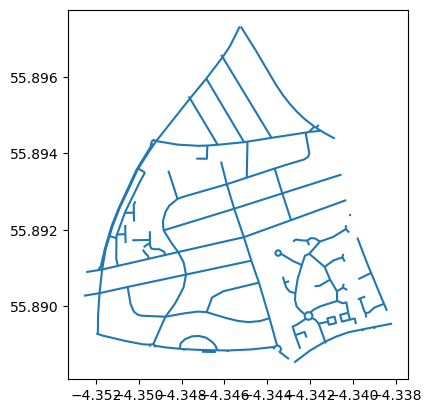

In [9]:
glasgow_pd = gpd.read_file(f"{path}/glasgow_polling_districts.geojson")
glasgow_pd_networks = [gpd.clip(ways, geom) for geom in glasgow_pd.geometry]

<function matplotlib.pyplot.show(close=None, block=None)>

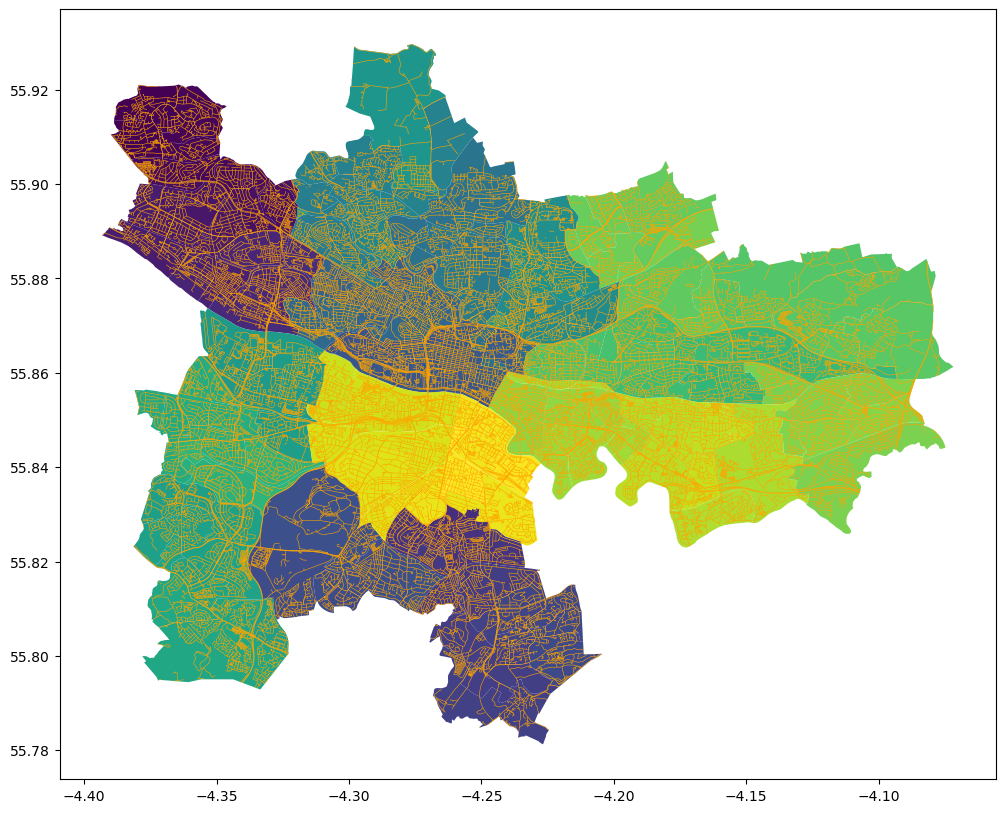

In [15]:
fig, ax = plt.subplots(1,1,figsize=(15,10))

ways_clip.plot(ax=ax, linewidth=0.4, edgecolor='orange')
glasgow_pd.plot(ax=ax, column='POLLING_DISTRICT', cmap='viridis')#facecolor='none', edgecolor='orange')
plt.show


<Axes: >

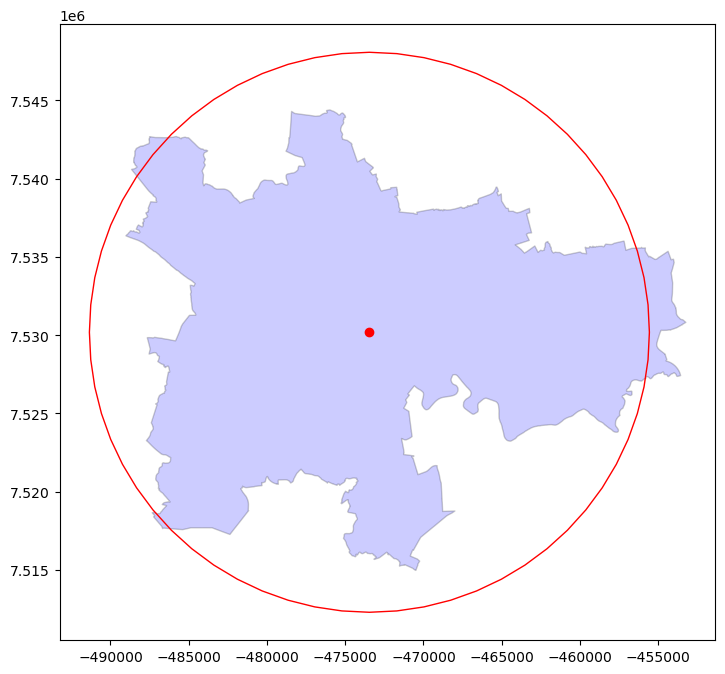

In [6]:
glasgow = glasgow.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10,8))
glasgow.plot(ax=ax, edgecolor='black', facecolor='blue', alpha=0.2)
glasgow.centroid.plot(ax=ax, color='red')

glasgow_w = glasgow.bounds.maxx[0] - glasgow.bounds.minx[0]

glasgow_buffer = glasgow.centroid.buffer(glasgow_w/2)

glasgow_buffer.plot(ax=ax, edgecolor='red', facecolor='none')

In [82]:
def n_buffer(n, poly):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0])/2
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    a = Point([poly.centroid.x, poly.centroid.y+poly_r])
    vertices = [a]
    for i in range(n):
        vertices.append(affinity.rotate(a, (360/n)*(i+1), origin=poly_c))
    print("vertices:", vertices)
    return gpd.GeoSeries(Polygon(vertices))

def n_buffer_lines(n, poly, rot=0):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0]) * 0.75
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    a = affinity.rotate(Point([poly.centroid.x, poly.centroid.y+poly_r]), rot, origin=poly_c)
    lines = [LineString([poly_c,[a.x, a.y]])]
    for i in range(n):
        vert_rotate = affinity.rotate(a, (360/n)*(i+1), origin=poly_c)
        lines.append(LineString([poly_c, [vert_rotate.x, vert_rotate.y]]))
    print("lines:", lines)
    return gpd.GeoSeries(lines)

def n_radial(n, poly, rot=0):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0])/2
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    buffer = poly.centroid.buffer(poly_r/2)
    a = affinity.rotate(Point([poly.centroid.x, poly.centroid.y+(poly_r*1.2)]), rot, origin=poly_c)
    lines = [LineString([poly_c,[a.x, a.y]])]
    vertices = [a]
    for i in range(n):
        vert_rotate = affinity.rotate(a, (360/n)*(i+1), origin=poly_c)
        vertices.append(vert_rotate)
        lines.append(LineString([poly_c, [vert_rotate.x, vert_rotate.y]]))

    return gpd.GeoDataFrame({'geometry' : lines}, geometry='geometry', crs=3857)

glasgow_r = (glasgow.bounds.maxx[0] - glasgow.bounds.minx[0])/2
glasgow_c = (glasgow.centroid.x[0], glasgow.centroid.y[0])
c = Point([glasgow.centroid.x, glasgow.centroid.y+glasgow_r])

#line = gpd.GeoDataFrame(geometry=gpd.GeoSeries(n_radial(7, glasgow, 10), crs=3857))
line = n_radial(7, glasgow, 10)

buff = glasgow.centroid.buffer(glasgow_r)[0]

buff_list = [glasgow.centroid.buffer(glasgow_r * (1 - i*0.25))[0] for i in range(4)]

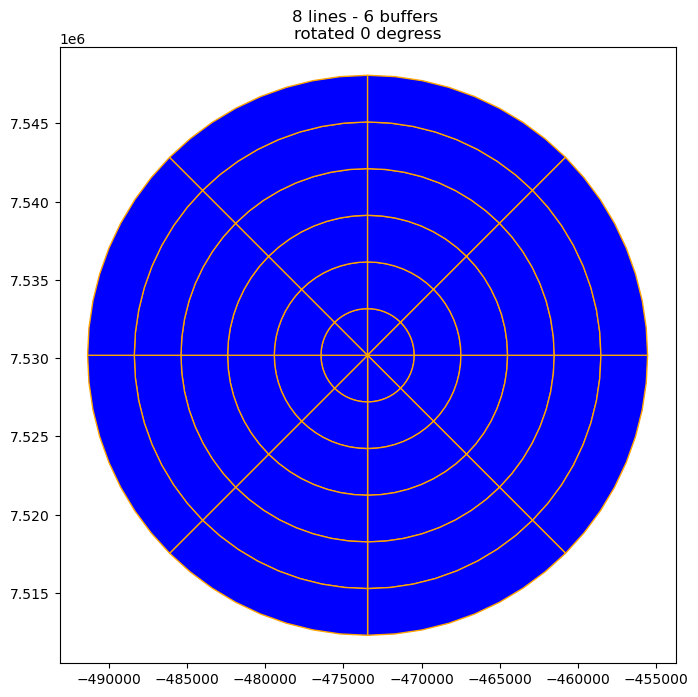

In [231]:
def find_overlaps(gdf):
    """Returns a list of tuples identifying the geometries
    that overlap one another.
    """
    overlaps, retouch = [], {}
    for x, y in combinations(gdf.index.tolist(), 2):
        g_x = gdf.loc[x].geometry
        g_y = gdf.loc[y].geometry
        if g_x.intersects(g_y):
            overlaps.append([x, y])

    for t, b in overlaps:
        retouch.setdefault(t, []).append(b)

    return overlaps, retouch


def clip_overlaps_by_weight(gdf, col, tol=0.0000001):
    """Clips out overlapping geometries within a shapefile
    ranked by an attribute.
    """

    gdf.sort_values(by=col, axis=0, ascending=False, inplace=True)
    gdf.reset_index(drop=True,inplace=True)
    dupd = gdf.geometry.duplicated()
    if dupd.any():  # keep highest weighted duplicate, remove the rest
        gdf = gdf.loc[~dupd]

    overlaps, retouch = find_overlaps(gdf)

    for overlap in overlaps:
        top, bot = gdf.loc[overlap].geometry
        try:
            bot = bot.difference(top)
        except:
            breakpoint()
        top = snap(top, bot, tol)
        gdf.loc[overlap, "geometry"] = gpd.GeoSeries([top, bot], index=overlap)

    for clipper, clip_list in retouch.items():
        for clipped in clip_list[:-1]:
            top, bot = gdf.loc[[clipper, clipped]].geometry
            gdf.loc[clipped, "geometry"] = snap(bot, top, tol)

    return gdf.reset_index(drop=True)

def n_radial(n, poly, rot=0):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0])/2
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    buffer = poly.centroid.buffer(poly_r/2)
    a = affinity.rotate(Point([poly.centroid.x, poly.centroid.y+(poly_r)]), rot, origin=poly_c) #poly_r*1.2
    lines = [LineString([poly_c,[a.x, a.y]])]
    vertices = [a]
    for i in range(n):
        vert_rotate = affinity.rotate(a, (360/n)*(i+1), origin=poly_c)
        vertices.append(vert_rotate)
        lines.append(LineString([poly_c, [vert_rotate.x, vert_rotate.y]]))

    return gpd.GeoDataFrame({'geometry' : lines}, geometry='geometry', crs=3857)

def radial_split(polygon, n=5, rot=0, buffers=4):
    # calculate centre and radius of input polygon
    polygon_r = (polygon.bounds.maxx[0] - polygon.bounds.minx[0])/2

    # generate buffers and remove overlapping areas
    buff_list = [polygon.centroid.buffer(polygon_r * (1 - i*(1/buffers)))[0] for i in range(buffers)]
    cut_buffers = clip_overlaps_by_weight(gpd.GeoDataFrame({'id': [x for x in range(len(buff_list))], 'geometry' : buff_list}, geometry='geometry'), 'id')
    
    # generate n radial lines and merge them into one single LineString   
    lines = n_radial(n, polygon, rot)
    points = [[point for point in line.coords] for line in lines.geometry[:]]
    merge_line = LineString([val for sublist in points for val in sublist])

    # divide the buffers using the radial linestring and return
    ring_split = [MultiPolygon(split(cut_buffers.geometry[i], merge_line)) for i in range(buffers)]
    # returns the split buffers AND the uncut buffers
    return gpd.GeoDataFrame(geometry=gpd.GeoSeries([poly for poly in ring_split])), gpd.GeoDataFrame({'geometry':buff_list}, geometry='geometry', crs=3857)

glasgow = glasgow.to_crs(3857)
glasgow_pd = glasgow_pd.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10,8))
glasgow_radial = radial_split(glasgow)

n = 8
rot = 0
buffers = 6

glasgow_radial, glasgow_buffers = radial_split(glasgow, n, rot, buffers)

glasgow_inner = glasgow_buffers.iloc[[-1]]
#inner_pds = glasgow_pd.sjoin(glasgow_inner)
glasgow.centroid.plot(ax=ax, color='green')

ax.set_title(f"{n} lines - {buffers} buffers \nrotated {rot} degress")
glasgow_radial.plot(ax=ax, edgecolor='orange', facecolor='blue')

plt.show()

multi_list [<MULTIPOLYGON (((-471487.02 7529827.689, -471497.202 7529620.443, -471527.64...>, <MULTIPOLYGON (((-469392.999 7529413.198, -469453.891 7529002.698, -469554.7...>, <MULTIPOLYGON (((-467380.135 7528590.202, -467531.387 7527986.37, -467741.09...>, <MULTIPOLYGON (((-465508.048 7527372.597, -465787.661 7526591.131, -466142.5...>]


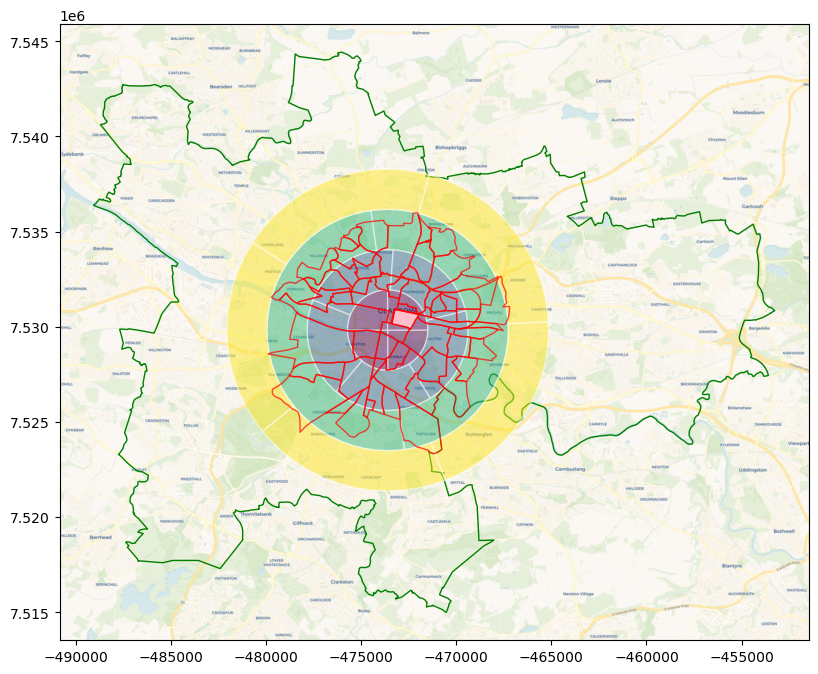

In [192]:
def find_overlaps(gdf):
    """Returns a list of tuples identifying the geometries
    that overlap one another.
    """
    overlaps, retouch = [], {}
    for x, y in combinations(gdf.index.tolist(), 2):
        g_x = gdf.loc[x].geometry
        g_y = gdf.loc[y].geometry
        if g_x.intersects(g_y):
            overlaps.append([x, y])

    for t, b in overlaps:
        retouch.setdefault(t, []).append(b)

    return overlaps, retouch


def clip_overlaps_by_weight(gdf, col, tol=0.0000001):
    """Clips out overlapping geometries within a shapefile
    ranked by an attribute.
    """

    gdf.sort_values(by=col, axis=0, ascending=False, inplace=True)
    gdf.reset_index(drop=True,inplace=True)
    dupd = gdf.geometry.duplicated()
    if dupd.any():  # keep highest weighted duplicate, remove the rest
        gdf = gdf.loc[~dupd]

    overlaps, retouch = find_overlaps(gdf)

    for overlap in overlaps:
        top, bot = gdf.loc[overlap].geometry
        try:
            bot = bot.difference(top)
        except:
            breakpoint()
        top = snap(top, bot, tol)
        gdf.loc[overlap, "geometry"] = gpd.GeoSeries([top, bot], index=overlap)

    for clipper, clip_list in retouch.items():
        for clipped in clip_list[:-1]:
            top, bot = gdf.loc[[clipper, clipped]].geometry
            gdf.loc[clipped, "geometry"] = snap(bot, top, tol)

    return gdf.reset_index(drop=True)

def n_radial(n, poly, rot=0):
    poly_r = (poly.bounds.maxx[0] - poly.bounds.minx[0])/2
    poly_c = (poly.centroid.x[0], poly.centroid.y[0])
    a = affinity.rotate(Point([poly.centroid.x, poly.centroid.y+(poly_r*1.2)]), randint(-rot,rot), origin=poly_c) #poly_r*1.2
    lines = [LineString([poly_c,[a.x, a.y]])]
    vertices = [a]
    for i in range(n):
        vert_rotate = affinity.rotate(a, (360/n)*(i+1), origin=poly_c)
        vertices.append(vert_rotate)
        lines.append(LineString([poly_c, [vert_rotate.x, vert_rotate.y]]))

    return gpd.GeoDataFrame({'geometry' : lines}, geometry='geometry', crs=3857)

def radial_split(polygon, n=5, rot=0, buffers=4):
    polygon = gpd.GeoSeries(polygon)
    # calculate centre and radius of input polygon
    polygon_r = (polygon.bounds.maxx[0] - polygon.bounds.minx[0])/1.5

    # generate buffers and remove overlapping areas
    buff_list = [polygon.centroid.buffer(polygon_r * (1 - i*(1/buffers)))[0] for i in range(buffers)]
    cut_buffers = clip_overlaps_by_weight(gpd.GeoDataFrame({'id': [x for x in range(len(buff_list))], 'geometry' : buff_list}, geometry='geometry'), 'id')
    
    ### if i want to offset the rotations, the buffers will stay the same, will need a set of lines for each buffer on it's own

    # generate n radial lines and merge them into one single LineString   


    polygon_temp = gpd.GeoDataFrame(geometry=gpd.GeoSeries(buff_list))
    multi_list = []
    for index in range(len(polygon_temp)):
        current = cut_buffers.iloc[[index]].reset_index(drop=True)
        lines = n_radial(randint(2,n), current, 60*index)
        points = [[point for point in line.coords] for line in lines.geometry[:]]
        merge_line = LineString([val for sublist in points for val in sublist])
        # divide the buffers using the radial linestring and return
        ring_split = split(current.geometry[0], merge_line)
        multi_list.append(MultiPolygon(ring_split))
    # returns the split buffers AND the uncut buffers
    print("multi_list", multi_list)
    return gpd.GeoDataFrame(geometry=gpd.GeoSeries([multipoly for multipoly in multi_list]), crs=3857), gpd.GeoDataFrame({'geometry':buff_list}, geometry='geometry', crs=3857)

glasgow_inner_pds = gpd.read_file(f"{path}/glasgow_inner_pds.geojson").set_crs(3857)

glasgow = glasgow.to_crs(3857)
glasgow_pd = glasgow_pd.to_crs(3857)

fig, ax = plt.subplots(1,1,figsize=(10,8))

n = 8
rot = 0
buffers = 4

#gpd.GeoSeries(glasgow_inner_pds.unary_union).plot(ax=ax, facecolor='none', edgecolor='green', alpha=0.4)
glasgow.plot(ax=ax, edgecolor='green', facecolor='none')
cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

glasgow_radial, glasgow_buffers = radial_split(gpd.GeoSeries(glasgow_inner_pds.unary_union), n, rot, buffers)

# glasgow_radial, glasgow_buffers = radial_split(glasgow, n, rot, buffers) 
#glasgow_inner = glasgow_buffers.iloc[[-1]]
#inner_pds = glasgow_pd.sjoin(glasgow_inner)
#glasgow.centroid.plot(ax=ax, color='green')

glasgow_radial.reset_index().plot(ax=ax, column='index', edgecolor='white', cmap='viridis', alpha=0.5)
glasgow_inner_pds.plot(ax=ax, edgecolor='red', facecolor='none', alpha=0.7)
glasgow_inner_pds.iloc[[-27]].plot(ax=ax, edgecolor='red', facecolor='pink', alpha=1)

plt.show()

0    POLYGON ((-472602.509 7530802.173, -472613.471...
Name: geometry, dtype: geometry
multi_list [<MULTIPOLYGON (((-472508.891 7530443.979, -472510.044 7530420.507, -472513.4...>, <MULTIPOLYGON (((-472271.724 7530397.034, -472278.62 7530350.541, -472286.23...>, <MULTIPOLYGON (((-472043.748 7530303.822, -472060.879 7530235.432, -472078.2...>, <MULTIPOLYGON (((-471831.717 7530165.917, -471863.385 7530077.409, -471903.5...>]


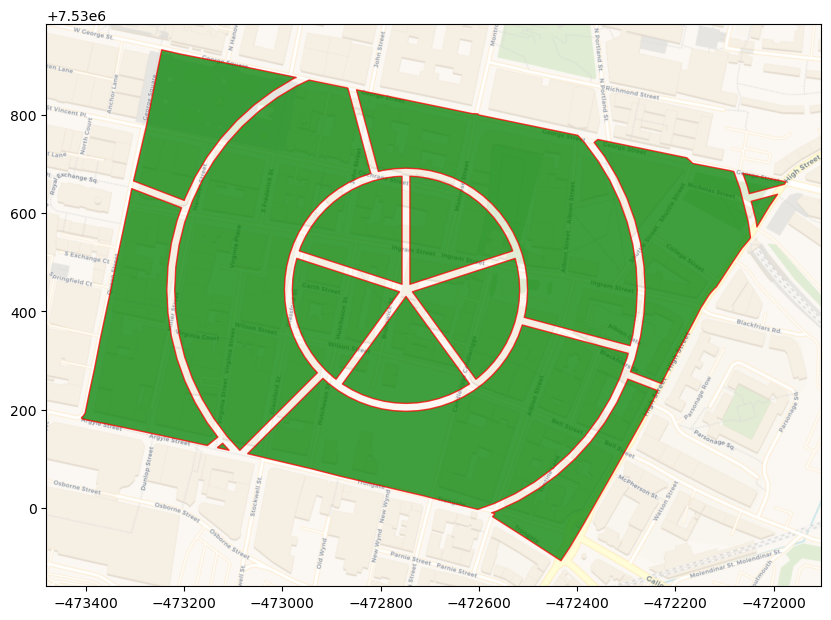

In [194]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

glasgow_inner_shape = gpd.GeoSeries(glasgow_inner_pds.unary_union).set_crs(3857)
glasgow_pd_27 = glasgow_inner_pds.iloc[[-27]]

print(glasgow_pd_27.geometry.reset_index(drop=True))

glasgow_27_radial, glasgow_buffers = radial_split(glasgow_pd_27.geometry.iloc[0], n, rot, buffers)

bleep = gpd.clip(glasgow_pd_27, glasgow_27_radial.buffer(-8))
#cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

#glasgow_radial.buffer(-100).plot(ax=ax)
bleep.plot(ax=ax, edgecolor='red', facecolor='green', alpha=0.75)
cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)



multi_list [<MULTIPOLYGON (((-472857.891 7530182.609, -472860.763 7530124.146, -472869.3...>, <MULTIPOLYGON (((-472267.178 7530065.683, -472284.356 7529949.883, -472312.8...>, <MULTIPOLYGON (((-471699.36 7529833.52, -471742.027 7529663.182, -471801.185...>, <MULTIPOLYGON (((-471171.254 7529490.04, -471250.131 7529269.593, -471350.23...>, <MULTIPOLYGON (((-470699.077 7529041.339, -470824.208 7528776.77, -470974.66...>, <MULTIPOLYGON (((-470298.18 7528495.603, -470478.734 7528194.368, -470687.94...>, <MULTIPOLYGON (((-469982.798 7527862.994, -470226.877 7527533.892, -470404.1...>, <MULTIPOLYGON (((-469765.809 7527155.504, -470080.279 7526808.54, -470427.24...>, <MULTIPOLYGON (((-469658.52 7526386.782, -470048.854 7526033.004, -470152.35...>, <MULTIPOLYGON (((-469670.466 7525571.936, -470095.783 7525256.5, -470431.639...>, <MULTIPOLYGON (((-469809.238 7524727.317, -470361.502 7524396.303, -470943.5...>, <MULTIPOLYGON (((-470080.334 7523870.275, -470715.298 7523569.959, -471376.6...>, <MUL

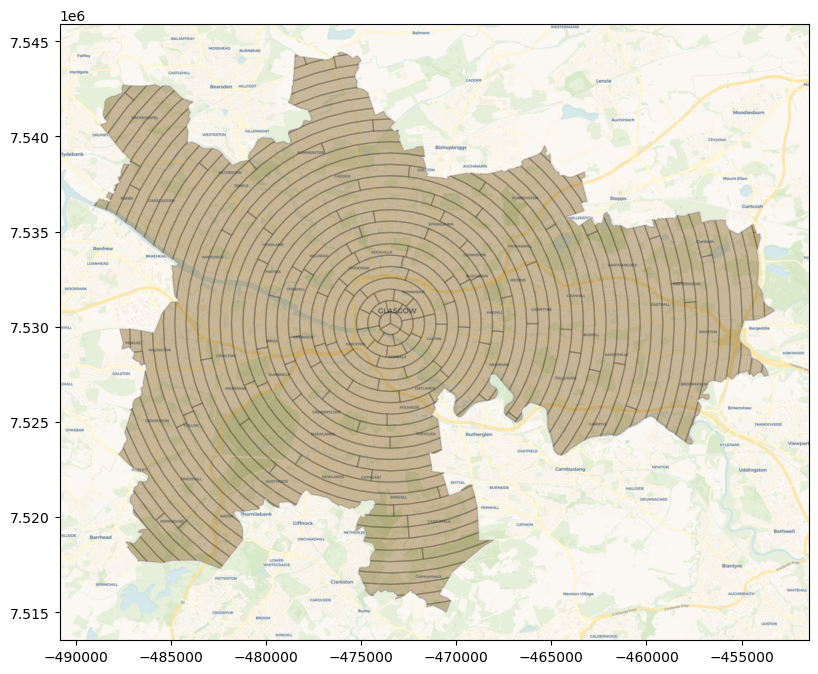

In [199]:
n = 10
rot = 10
buffers = 40

glasgow_full_radial, glasgow_buffers = radial_split(glasgow.geometry.iloc[0], n, rot, 40)

print(list(glasgow_full_radial.iloc[[0]].geometry[0].geoms))

polygons_all = [[poly for poly in multi.geoms] for multi in glasgow_full_radial.geometry]
glasgow_radial_flat = gpd.GeoDataFrame({'geometry':[val for sublist in polygons_all for val in sublist]}, crs=3857)

radial_overlay = gpd.overlay(glasgow, glasgow_full_radial, how='symmetric_difference', keep_geom_type=True)

radial_clip = gpd.sjoin(glasgow_full_radial, glasgow, predicate='intersects')
radial_clip = glasgow_radial_flat.clip(glasgow)

fig, ax = plt.subplots(1,1,figsize=(10,8))
glasgow.plot(ax=ax, edgecolor='white', facecolor='none')
cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

#glasgow_full_radial.plot(ax=ax, edgecolor='white', facecolor='blue', alpha=0.2)
radial_clip.plot(ax=ax, edgecolor='black', facecolor='red', alpha=0.2)
radial_clip.buffer(-8).plot(ax=ax, facecolor='green', alpha=0.2)

radial_clip.buffer(-8).to_file(f"{path}/radial_buffer_test.geojson")



multi_list [<MULTIPOLYGON (((-483641.75 7536966.667, -483642.271 7536956.066, -483643.82...>, <MULTIPOLYGON (((-483534.63 7536945.464, -483537.745 7536924.465, -483542.90...>, <MULTIPOLYGON (((-483431.662 7536903.363, -483439.399 7536872.474, -483450.1...>, <MULTIPOLYGON (((-483335.895 7536841.077, -483350.198 7536801.101, -483368.3...>, <MULTIPOLYGON (((-483250.27 7536759.709, -483272.961 7536711.732, -483300.24...>, <MULTIPOLYGON (((-483177.571 7536660.745, -483210.313 7536606.119, -483248.2...>, <MULTIPOLYGON (((-483120.38 7536546.028, -483164.641 7536486.348, -483205.66...>, <MULTIPOLYGON (((-483081.031 7536417.731, -483138.057 7536354.813, -483200.9...>, <MULTIPOLYGON (((-483061.575 7536278.331, -483132.359 7536214.177, -483209.0...>, <MULTIPOLYGON (((-483063.742 7536130.567, -483148.998 7536067.336, -483240.0...>]
multi_list [<MULTIPOLYGON (((-471416.007 7518788.297, -471416.406 7518780.173, -471417.5...>, <MULTIPOLYGON (((-471333.923 7518772.049, -471336.31 7518755.958, -471340.

<Axes: >

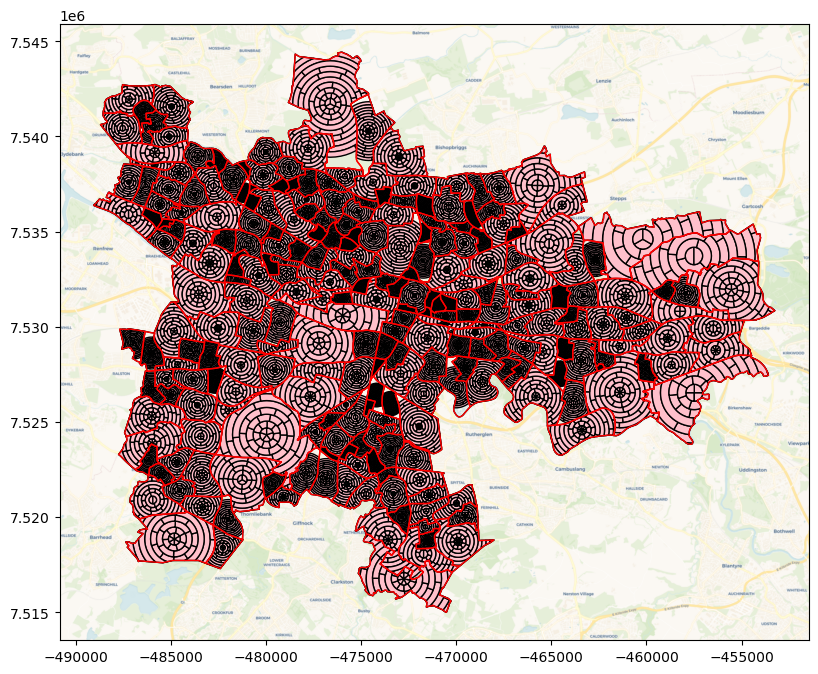

In [204]:
def gdf_radials(gdf, max_n, max_rot, buffers):
    gdf_out = gpd.GeoDataFrame({'geometry':[]}, crs=3857)
    for i in range(len(gdf)):
        gdf_current, _ = radial_split(gdf.iloc[[i]].geometry.iloc[0], max_n, max_rot, buffers)
        polygons_all = [[poly for poly in multi.geoms] for multi in gdf_current.geometry]
        gdf_current_flat = gpd.GeoDataFrame({'geometry':[val for sublist in polygons_all for val in sublist]}, crs=3857)
        gdf_current = gdf_current_flat.clip(gdf.iloc[[i]].geometry.iloc[0])
        gdf_out = pd.concat([gdf_out, gdf_current])
    return gdf_out

test = gdf_radials(glasgow_pd, 10, 10, 10)

fig, ax = plt.subplots(1,1,figsize=(10,8))

glasgow.plot(ax=ax, edgecolor='black', facecolor='none')
cx.add_basemap(ax, crs='EPSG:3857', attribution=False, source=cx.providers.CartoDB.Voyager)

test.plot(ax=ax, edgecolor='black', facecolor='pink')
glasgow_pd.plot(ax=ax, edgecolor='red', facecolor='none')